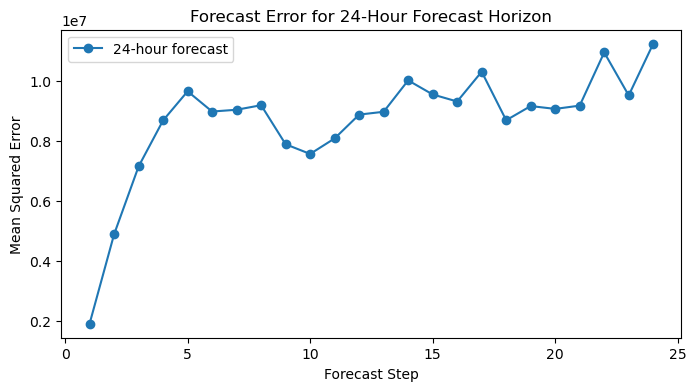

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Load the imputed dataset
data = pd.read_csv('midatl_forecast_load_imputed.csv', index_col=0)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

# Define a function to prepare data for a given look-back and forecast horizon
def create_multi_step_dataset(dataset, look_back=24, forecast_steps=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back - forecast_steps + 1):
        X.append(dataset[i:(i + look_back), 0])  # Input: Last 24 hours
        Y.append(dataset[i + look_back:i + look_back + forecast_steps, 0])  # Output: Next forecast_steps hours
    return np.array(X), np.array(Y)

# Define FNN model
class MultiStepStackModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiStepStackModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train and evaluate the model for a 24-hour forecast horizon
def train_and_evaluate(forecast_steps=24):
    # Prepare the data with a 24-hour look-back and 24-hour forecast
    X, y = create_multi_step_dataset(data_normalized, look_back=24, forecast_steps=forecast_steps)

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Convert to PyTorch tensors
    X_train = Variable(torch.Tensor(X_train))
    X_test = Variable(torch.Tensor(X_test))
    y_train = Variable(torch.Tensor(y_train))
    y_test = Variable(torch.Tensor(y_test))

    # Instantiate the model
    input_size = 24  # 24-hour look-back
    hidden_size = 50
    output_size = forecast_steps  # Number of forecast steps (24)
    stack_model = MultiStepStackModel(input_size, hidden_size, output_size)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(stack_model.parameters(), lr=0.01)

    # Training loop
    epochs = 100
    for epoch in range(epochs):
        stack_model.train()
        optimizer.zero_grad()
        outputs = stack_model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    stack_model.eval()
    predictions = stack_model(X_test).detach().numpy()
    y_test_actual = y_test.numpy()

    # Denormalize predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test_actual)

    # Calculate Mean Squared Error for each forecast step
    mse_per_step = np.mean((predictions - y_test_actual) ** 2, axis=0)

    return mse_per_step  # Returns MSE for each step in the 24-hour forecast

# Run evaluation for a 24-hour forecast
mse_per_step = train_and_evaluate(forecast_steps=24)

# Plot MSE for each forecast step within the 24-hour horizon
plt.figure(figsize=(8, 4))
plt.plot(range(1, 25), mse_per_step, marker='o', label='24-hour forecast')
plt.xlabel('Forecast Step')
plt.ylabel('Mean Squared Error')
plt.title('Forecast Error for 24-Hour Forecast Horizon')
plt.legend()
plt.show()